## Prerequisite code

In [38]:
# Import libraries that we will use later in this notebook
import os
import ccdproc
import numpy as np
from astropy import units as u
from matplotlib.colors import LogNorm
from ccdproc import CCDData
import matplotlib.pyplot as plt

# Make images non-blurry on high pixel density screens
%config InlineBackend.figure_format = 'retina'

# Make images look nice on high pixel density screens
%config InlineBackend.figure_format = 'retina'

# Title size
plt.rcParams['axes.titlesize'] = 16

# Axes label size
plt.rcParams['axes.labelsize'] = 13


def show_image(image, title):
    """
    Display an image.
    
    Parameters
    ---------
    
    image: CCDData
        A fits image to show.
        
    title: str
        Plot title.
    """
    fig, ax = plt.subplots(figsize=(12, 8))  # Change image size
    plt.rcParams.update({'font.size': 10})  # Change font size
    plt.imshow(image, cmap='winter', norm=LogNorm())  # Set color map and pixel scaling
    plt.xlabel('x [pixel]')  # Set axis labels
    plt.ylabel('y [pixel]')
    plt.title(title, y=-0.2)  # Set image title
    plt.colorbar()  # Show color bar
    

def print_image_stats(image, title):
    """
    Print first pixel value, average and standard deviation for an image.
    
    Parameters
    ---------
    
    image: CCDData
        A fits image to show.
        
    title: str
        Image name.
    """
    
    data = np.asarray(image)# Get numpy array for image data
    label_len = 10  # Length of the text label
    first_pixel = data[0, 0]  # First pixel
    average = np.mean(data)  # Average
    standard_deviation = np.std(data)   # Standard deviation


    # Print values
    # -------

    print(
        f'\n{title}',
        f"\n{'-' * len(title)}",
        f"\n{'Pixel:':<10}{first_pixel:>10.2f} ADU",
        f"\n{'Avg:':<10}{average:>10.2f} ADU",
        f"\n{'Std:':<10}{standard_deviation:>10.2f} ADU\n"
    )

## Reducing flats

* We are using flat files from March_09_2018.zip
* Checking visually with DS9 to make sure there are no stars in the flats. 
* Keep five flats for B, I, R, V filters (we don't need U).

In [55]:
def reduce_flats_for_filter(filter, fits_path, bias, dark):
    """
    Reduce the flat files for the given filter
    
    Parameters
    ----------
    
    filter: str
        Name of the filter: 'V', 'B' etc.
        
    fits_path: str
        Directory where flat files are located.
        
    bias: image
        Reduced bias image.
        
    dark: image
        Reduced dark image
    """
    
    print(f"\nReducing flats for {filter} filter:")
    
    # Get names of all image files in current directory
    images = ccdproc.ImageFileCollection(fits_path, glob_include = f'Flat_{filter}_*')
    images = images.files_filtered(PICTTYPE = 4)

    for image in images:
        print(image)
        
    # Read the images and store them in a list
    # --------

    flats = [
                CCDData.read(os.path.join(fits_path, fn), unit="adu")
                for fn in images
            ]
    
    print_image_stats(flats[0], title=f"First Flat {filter}")
    print(f"First flat exposure time: {flats[0].header['EXPTIME']} s")

    
    # Subtract median bias from each flat image and store results in a list
    # --------

    flats_bias_subtracted = [
        ccdproc.subtract_bias(image, bias)
        for image in flats
    ]
    
    print_image_stats(flats_bias_subtracted[0], title=f"First Flat, bias subtracted {filter}")
    
    # Subtract dark median image from flats.
    # We also scale by exposure time to make sure
    # the effective exposures of two images are equal.
    # --------

    flats_bias_dark_subtracted = [
        ccdproc.subtract_dark(image, dark, exposure_time='EXPTIME',
                              exposure_unit=u.second, scale=True)
        for image in flats_bias_subtracted
    ]
    
    print_image_stats(flats_bias_dark_subtracted[0],
                      title=f"First Flat, bias and dark subtracted {filter}")
    
    
    # Make a copy of the Flats array to avoid modifying it
    tempimages = flats_bias_dark_subtracted.copy()
      

    # Scale each flat image, such that median pixel has value of 1
    # -------
        
    flats_scaled = [ 
                        file.multiply(1.0 / np.ma.median(tempimages[idx]) * u.adu)
                        for file in flats_bias_dark_subtracted
                   ]

    # Median combine Flats
    flat_median = ccdproc.Combiner(flats_scaled).median_combine()
    
    return flat_median

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

Bias 
---- 
Pixel:        135.00 ADU 
Avg:          109.08 ADU 
Std:            6.83 ADU

Bias exposure time: 0 s
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

Dark 
---- 
Pixel:          0.00 ADU 
Avg:           12.66 ADU 
Std:          213.09 ADU

Dark exposure time: 600 s

Reducing flats for R filter:
Flat_R_4.000secs_00001427.fit
Flat_R_4.000secs_00001428.fit
Flat_R_4.000secs_00001429.fit
Flat_R_4.000secs_00001430.fit
Flat_R_4.000secs_00001431.fit

First Flat R 
------------ 
Pixel:       2218.00 ADU 
Avg:         2165.94 ADU 
Std:           32.08 ADU

First flat exposure time: 4.0 s

First Flat, bias subtracted R 
----------------------------- 
Pixel:       2083.00 ADU 
Avg:         2056.86 ADU 
Std:           31.36 ADU


First Flat, bias and dark subtracted R 
-------------------------------

NameError: name 'idx' is not defined

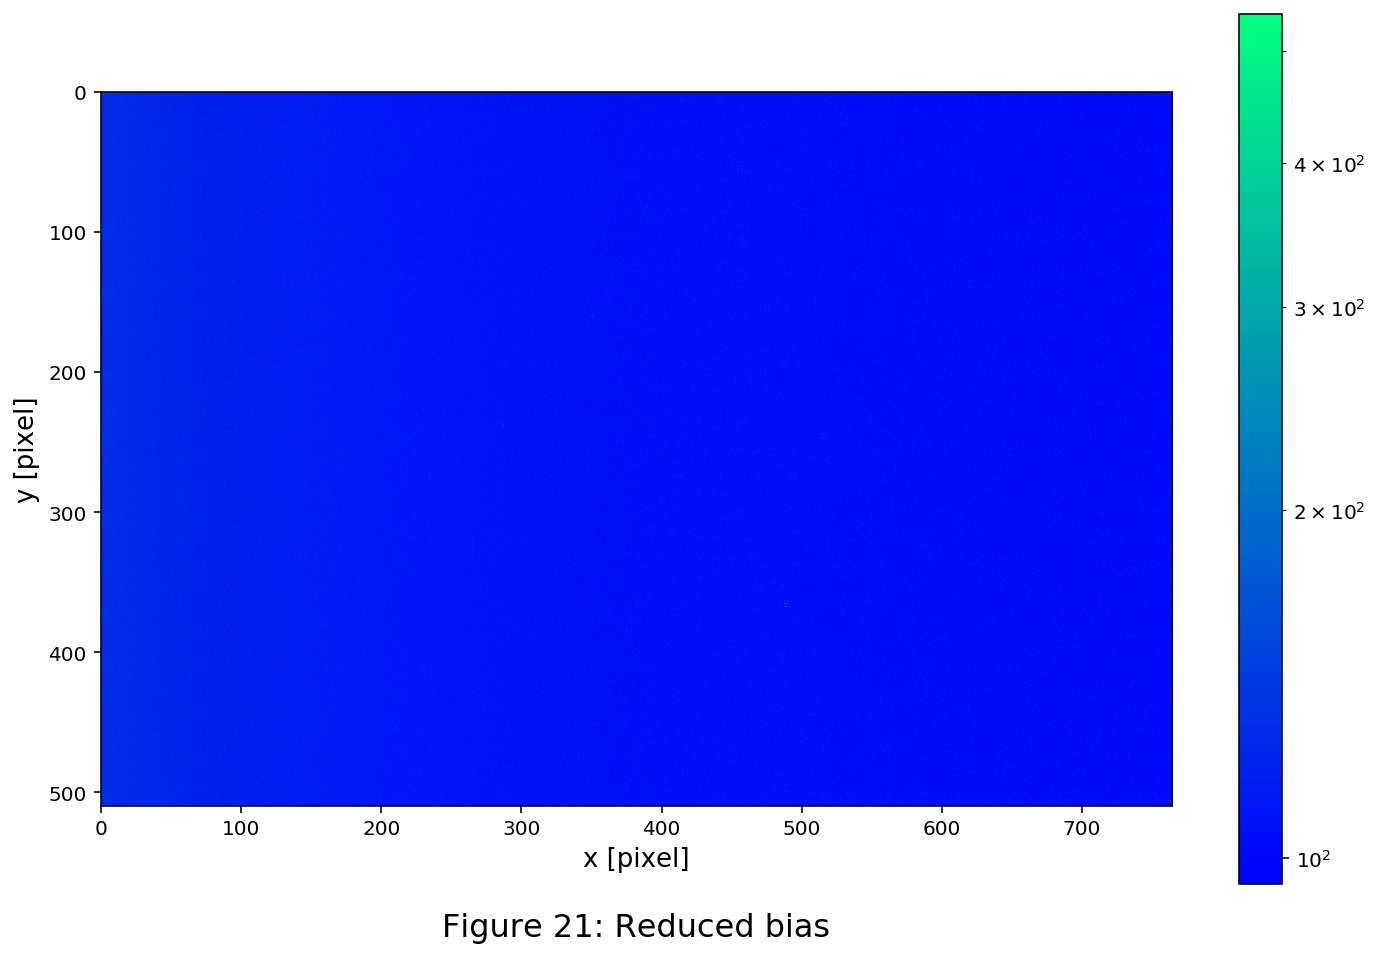

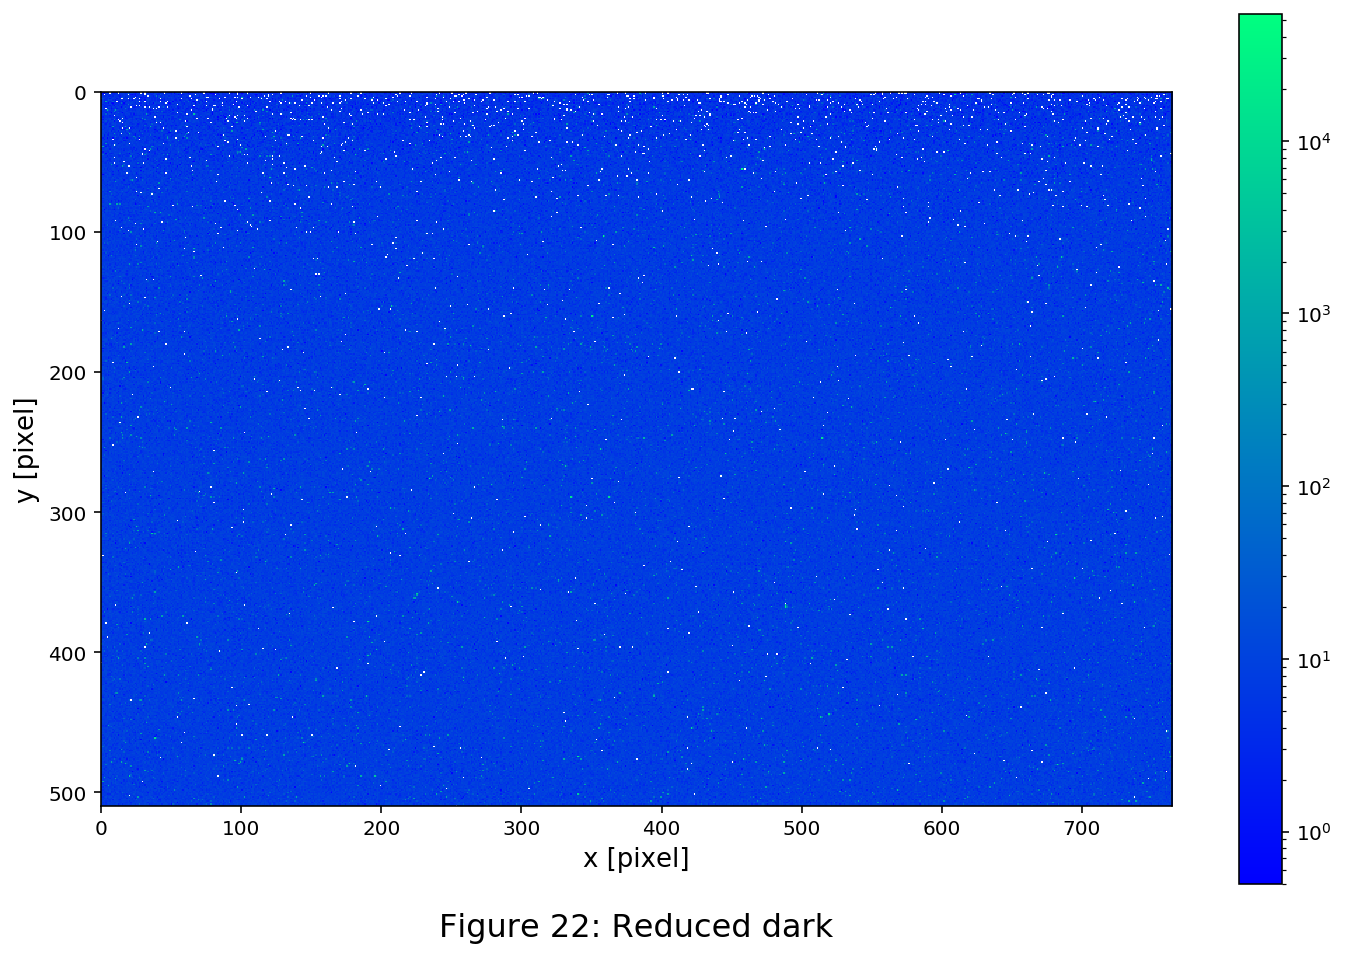

In [56]:
data_dir = './data/'

# Load bias
bias = CCDData.read(os.path.join(data_dir, 'bias_median.fits'), unit="adu")
show_image(bias, title='Figure 21: Reduced bias')
print_image_stats(bias, title="Bias")
print(f"Bias exposure time: {bias.header['EXPTIME']} s")

# Load dark
dark = CCDData.read(os.path.join(data_dir, 'dark_median.fits'), unit="adu")
show_image(dark, title='Figure 22: Reduced dark')
print_image_stats(dark, title="Dark")
print(f"Dark exposure time: {dark.header['EXPTIME']} s")

flat = reduce_flats_for_filter(filter='R',
                               fits_path=os.path.join(data_dir, 'flats'),
                                bias=bias, dark=dark)

print_image_stats(flat, title='Scaled median-combined Flat image')
